# 1. Import data

In [ ]:
# INSTALL
#!pip install --user xgboost pyod imutils mlxtend

In [18]:
import cv2
import matplotlib.pyplot as plt
import glob
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import imutils
from pyod.models.iforest import IForest
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.loda import LODA
from pyod.models.vae import VAE
from pyod.models.xgbod import XGBOD
from pyod.models.abod import ABOD
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [2]:
def quantify_image(image, bins=(4, 6, 3)):
    # compute a 3D color histogram over the image and normalize it
    hist = cv2.calcHist([image], [0, 1, 2], None, [16, 16, 16],
        [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    # return the histogram
    return hist

In [3]:
images=[]
features = []
PATH = 'GTSRB\Final_Training\Images'
for filename in tqdm(glob.glob(os.path.join(PATH, '*\*.ppm'))):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = imutils.resize(img, width=100)
    images.append(img)

100%|███████████████████████████████████████████████████████████████████████████| 39209/39209 [04:09<00:00, 157.33it/s]


In [4]:
images = np.asarray(images)
images.shape

C:\Users\nbelh\AppData\Roaming\Python\Python37\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


(39209,)

In [5]:
labels = []
for filename in tqdm(glob.glob(os.path.join(PATH, '*\*.csv'))):
    labels.append(np.genfromtxt(filename, delimiter=';',skip_header=1,dtype='int32'))

100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 61.10it/s]


In [6]:
labels = np.vstack(labels)[:,-1]
labels.shape

(39209,)

# 2. Combine data

In [7]:
all_data = np.column_stack((images,labels))

In [8]:
import pandas as pd

df = pd.DataFrame(data=all_data)
df = df.rename(columns={0: "ppm_image", df.columns[-1]: "label"})
df.tail()

,ppm_image,label
39204,"[[[13, 11, 12], [13, 11, 12], [11, 11, 12], [1...",42
39205,"[[[11, 9, 10], [11, 9, 10], [10, 9, 11], [10, ...",42
39206,"[[[10, 10, 12], [11, 11, 13], [12, 12, 14], [1...",42
39207,"[[[14, 13, 15], [14, 13, 15], [13, 13, 15], [1...",42
39208,"[[[10, 9, 11], [10, 9, 11], [10, 9, 11], [10, ...",42


In [9]:
df_stop = df[df.iloc[:,-1] == 14]
df_stop = df_stop.reset_index(drop=True)
df_stop.shape

(780, 2)

In [10]:
features = []
for img in df_stop['ppm_image']:
    features.append(quantify_image(img))
features = np.asarray(features)
df_stop = pd.concat([df_stop, pd.DataFrame(features)], axis=1)
df_stop.shape

(780, 4098)

# 3. Visualize data

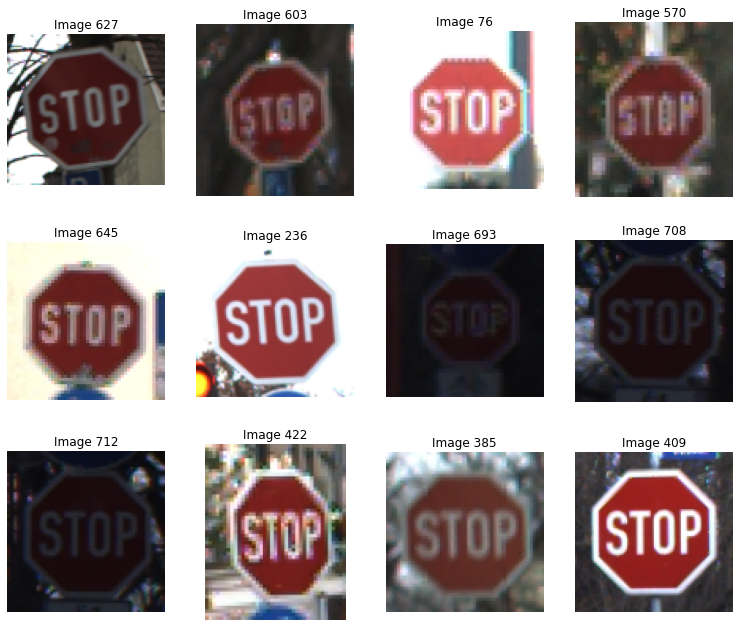

In [11]:
# Show a grid of MxN randomly selected samples from the training data

grid_m = 3
grid_n = 4
rand_grid = np.random.randint(df_stop.shape[0], size=[grid_m,grid_n])

f0, cell0 = plt.subplots(grid_m, grid_n, figsize=(13,11))
for i in range(grid_m):
    for j in range(grid_n):
        cell0[i, j].imshow(df_stop['ppm_image'][rand_grid[i,j]])
        cell0[i, j].axis('off')
        cell0[i, j].set_title('Image {}'.format(rand_grid[i,j]))
        
plt.savefig('stop_signs.png', dpi=300, bbox_inches='tight')

In [12]:
df_train, df_test = train_test_split(df_stop, test_size=0.15)

print(df_train.shape)
print(df_test.shape)

(663, 4098)
(117, 4098)


In [13]:
df_outliers = df[df['label']==9].sample(10)
df_outliers = df_outliers.append(df[df['label']==17].sample(10))
df_outliers.reset_index(drop=True, inplace=True)
features = []
for img in df_outliers['ppm_image']:
    features.append(quantify_image(img))
features = np.asarray(features)

df_outliers = pd.concat([df_outliers, pd.DataFrame(features)], axis=1)
df_outliers.shape

(20, 4098)

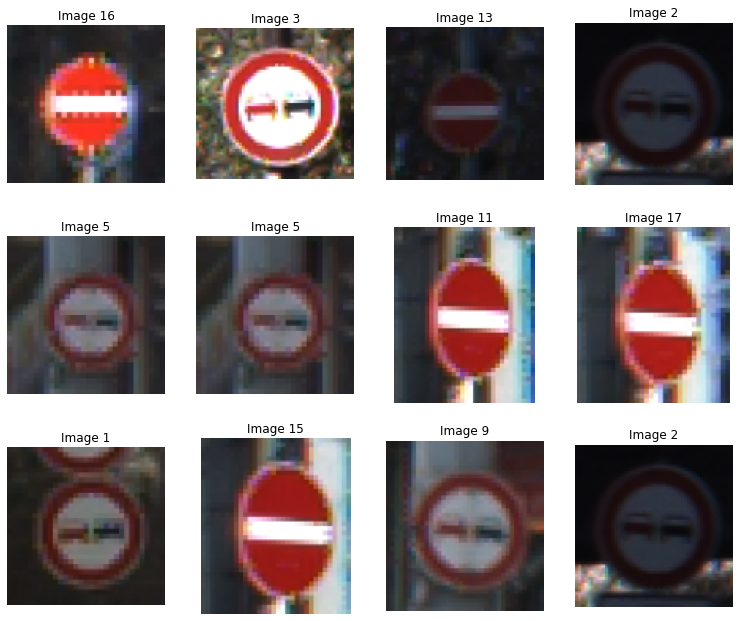

In [14]:
# Show a grid of MxN randomly selected samples from the training data

grid_m = 3
grid_n = 4
rand_grid = np.random.randint(df_outliers.shape[0], size=[grid_m,grid_n])

f0, cell0 = plt.subplots(grid_m, grid_n, figsize=(13,11))
for i in range(grid_m):
    for j in range(grid_n):
        cell0[i, j].imshow(df_outliers['ppm_image'][rand_grid[i,j]])
        cell0[i, j].axis('off')
        cell0[i, j].set_title('Image {}'.format(rand_grid[i,j]))
        
plt.savefig('outliers.png', dpi=300, bbox_inches='tight')

In [15]:
df_test = df_test.append(df_outliers)
df_test.shape

(137, 4098)

In [16]:
df_train.head()

,ppm_image,label,0,1,2,3,4,5,6,7,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
216,"[[[93, 112, 116], [93, 112, 116], [106, 115, 1...",14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.006751,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
139,"[[[134, 131, 86], [115, 118, 77], [103, 112, 7...",14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.004126,0.033601,0.040674,0.04598,0.046569,0.037138,0.058948,0.822920
204,"[[[111, 163, 155], [192, 226, 223], [239, 255,...",14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.547073
387,"[[[48, 51, 49], [49, 52, 50], [52, 53, 53], [5...",14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000428,0.035488
44,"[[[255, 255, 254], [253, 253, 252], [205, 207,...",14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.004299,0.021166,0.940251


# 4. Find Optimal Contamination:

In [20]:
true = df_test['label']!=14

## 4.1. Isolation Forest

In [21]:
if_accuracies={}
for x in np.arange(0.01,0.51,0.03):
    model_if = IForest(n_estimators=100, contamination=x, n_jobs=-1, random_state=42)
    model_if.fit(df_train.iloc[:,2:])
    preds_if = model_if.predict(df_test.iloc[:,2:])
    if_accuracies[x] = metrics.f1_score(true, preds_if)

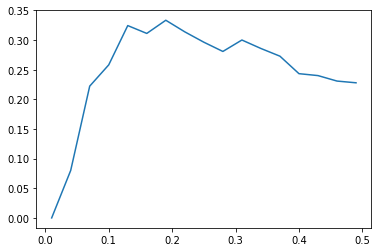

In [22]:
plt.plot(if_accuracies.keys(), if_accuracies.values())

## 4.2. Auto Encoders

In [23]:
ae_accuracies={}
for x in np.arange(0.01,0.51,0.03):
    model_ae = AutoEncoder(epochs=10, random_state=42, contamination=x)
    model_ae.fit(df_train.iloc[:,2:])
    preds_ae = model_ae.predict(df_test.iloc[:,2:])
    ae_accuracies[x] = metrics.f1_score(true, preds_ae)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              16781312  
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                262208    
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2

19/19 [==============================] - 4s 163ms/step - loss: 230.9025 - val_loss: 388.0619
Epoch 2/10
19/19 [==============================] - 3s 151ms/step - loss: 187.9265 - val_loss: 843.5231
Epoch 3/10
19/19 [==============================] - 3s 150ms/step - loss: 88.0196 - val_loss: 1160.2245
Epoch 4/10
19/19 [==============================] - 3s 154ms/step - loss: 38.0837 - val_loss: 1637.2365
Epoch 5/10
19/19 [==============================] - 3s 149ms/step - loss: 20.5378 - val_loss: 2053.3604
Epoch 6/10
19/19 [==============================] - 3s 148ms/step - loss: 10.9724 - val_loss: 2442.6265
Epoch 7/10
19/19 [==============================] - 3s 149ms/step - loss: 7.2209 - val_loss: 2720.1367
Epoch 8/10
19/19 [==============================] - 3s 149ms/step - loss: 5.4477 - val_loss: 2999.0198
Epoch 9/10
19/19 [==============================] - 3s 152ms/step - loss: 4.6387 - val_loss: 3245.2571
Epoch 10/10
19/19 [==============================] - 3s 151ms/step - loss: 4.0

19/19 [==============================] - 5s 176ms/step - loss: 253.4794 - val_loss: 282.7956
Epoch 2/10
19/19 [==============================] - 3s 163ms/step - loss: 180.1349 - val_loss: 474.9029
Epoch 3/10
19/19 [==============================] - 3s 167ms/step - loss: 76.0610 - val_loss: 642.2083
Epoch 4/10
19/19 [==============================] - 3s 163ms/step - loss: 41.6193 - val_loss: 905.6593
Epoch 5/10
19/19 [==============================] - 3s 162ms/step - loss: 24.4649 - val_loss: 1220.9330
Epoch 6/10
19/19 [==============================] - 3s 168ms/step - loss: 13.0256 - val_loss: 1505.5239
Epoch 7/10
19/19 [==============================] - 3s 164ms/step - loss: 8.4725 - val_loss: 1741.1379
Epoch 8/10
19/19 [==============================] - 3s 165ms/step - loss: 5.9722 - val_loss: 1890.3098
Epoch 9/10
19/19 [==============================] - 3s 175ms/step - loss: 4.7637 - val_loss: 2029.5833
Epoch 10/10
19/19 [==============================] - 3s 179ms/step - loss: 4.024

19/19 [==============================] - 4s 180ms/step - loss: 245.7037 - val_loss: 366.0229
Epoch 2/10
19/19 [==============================] - 3s 158ms/step - loss: 161.4567 - val_loss: 889.3153
Epoch 3/10
19/19 [==============================] - 3s 167ms/step - loss: 84.9459 - val_loss: 1332.0156
Epoch 4/10
19/19 [==============================] - 3s 175ms/step - loss: 42.8470 - val_loss: 1923.6855
Epoch 5/10
19/19 [==============================] - 3s 164ms/step - loss: 22.6466 - val_loss: 2626.7292
Epoch 6/10
19/19 [==============================] - 3s 152ms/step - loss: 12.8357 - val_loss: 3187.7605
Epoch 7/10
19/19 [==============================] - 3s 156ms/step - loss: 7.4615 - val_loss: 3629.3220
Epoch 8/10
19/19 [==============================] - 3s 156ms/step - loss: 5.6026 - val_loss: 3973.5144
Epoch 9/10
19/19 [==============================] - 3s 148ms/step - loss: 4.4048 - val_loss: 4180.3955
Epoch 10/10
19/19 [==============================] - 3s 150ms/step - loss: 3.8

19/19 [==============================] - 4s 170ms/step - loss: 246.9759 - val_loss: 323.3189
Epoch 2/10
19/19 [==============================] - 3s 170ms/step - loss: 164.4571 - val_loss: 611.2883
Epoch 3/10
19/19 [==============================] - 3s 161ms/step - loss: 81.2556 - val_loss: 840.9315
Epoch 4/10
19/19 [==============================] - 3s 158ms/step - loss: 32.5886 - val_loss: 1183.2789
Epoch 5/10
19/19 [==============================] - 3s 155ms/step - loss: 18.7071 - val_loss: 1531.7800
Epoch 6/10
19/19 [==============================] - 3s 165ms/step - loss: 10.8991 - val_loss: 1872.7330
Epoch 7/10
19/19 [==============================] - 3s 168ms/step - loss: 6.7950 - val_loss: 2071.2214
Epoch 8/10
19/19 [==============================] - 3s 161ms/step - loss: 5.1940 - val_loss: 2239.0479
Epoch 9/10
19/19 [==============================] - 3s 156ms/step - loss: 4.3403 - val_loss: 2375.6919
Epoch 10/10
19/19 [==============================] - 3s 154ms/step - loss: 3.81

19/19 [==============================] - 5s 191ms/step - loss: 253.4447 - val_loss: 260.8770
Epoch 2/10
19/19 [==============================] - 3s 172ms/step - loss: 169.0804 - val_loss: 381.1241
Epoch 3/10
19/19 [==============================] - 3s 170ms/step - loss: 96.4978 - val_loss: 694.3956
Epoch 4/10
19/19 [==============================] - 3s 171ms/step - loss: 37.1049 - val_loss: 867.5309
Epoch 5/10
19/19 [==============================] - 3s 162ms/step - loss: 19.6511 - val_loss: 1097.8049
Epoch 6/10
19/19 [==============================] - 3s 166ms/step - loss: 11.4770 - val_loss: 1354.5413
Epoch 7/10
19/19 [==============================] - 3s 166ms/step - loss: 7.3524 - val_loss: 1549.8849
Epoch 8/10
19/19 [==============================] - 3s 169ms/step - loss: 5.5300 - val_loss: 1720.1033
Epoch 9/10
19/19 [==============================] - 3s 172ms/step - loss: 4.3595 - val_loss: 1795.9598
Epoch 10/10
19/19 [==============================] - 3s 165ms/step - loss: 3.986

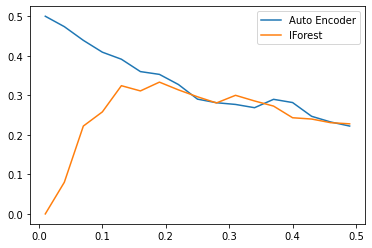

In [24]:
plt.plot(ae_accuracies.keys(), ae_accuracies.values(), label='Auto Encoder')
plt.plot(if_accuracies.keys(), if_accuracies.values(), label='IForest')
plt.legend()
plt.show()

## 4.3. LODA

In [26]:
loda_accuracies={}
for x in np.arange(0.01,0.51,0.03):
    model_loda = LODA(contamination=x, n_bins=10, n_random_cuts=100)
    model_loda.fit(df_train.iloc[:,2:])
    preds_loda = model_loda.predict(df_test.iloc[:,2:])
    loda_accuracies[x] = metrics.f1_score(true, preds_loda)

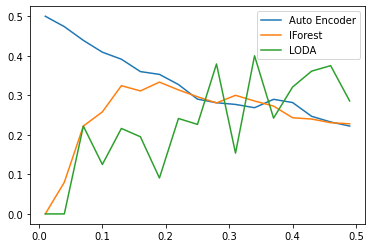

In [27]:
plt.plot(ae_accuracies.keys(), ae_accuracies.values(), label='Auto Encoder')
plt.plot(if_accuracies.keys(), if_accuracies.values(), label='IForest')
plt.plot(loda_accuracies.keys(), loda_accuracies.values(), label='LODA')
plt.legend()
plt.show()

## 4.4. VAE

In [28]:
vae_accuracies={}
for x in np.arange(0.01,0.51,0.03):
    model_vae = VAE(random_state=42, contamination=x, epochs = 10)
    model_vae.fit(df_train.iloc[:,2:])
    preds_vae = model_vae.predict(df_test.iloc[:,2:])
    vae_accuracies[x] = metrics.f1_score(true, preds_vae)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4096)]       0                                            
__________________________________________________________________________________________________
dense_119 (Dense)               (None, 4096)         16781312    input_1[0][0]                    
__________________________________________________________________________________________________
dense_120 (Dense)               (None, 128)          524416      dense_119[0][0]                  
__________________________________________________________________________________________________
dropout_102 (Dropout)           (None, 128)          0           dense_120[0][0]                  
______________________________________________________________________________________________

19/19 [==============================] - 4s 143ms/step - loss: 2785.9527 - val_loss: 4041.5725
Epoch 2/10
19/19 [==============================] - 2s 131ms/step - loss: 3303.7338 - val_loss: 3591.4863
Epoch 3/10
19/19 [==============================] - 2s 117ms/step - loss: 1853.9484 - val_loss: 3580.6348
Epoch 4/10
19/19 [==============================] - 2s 123ms/step - loss: 1726.4637 - val_loss: 3598.8816
Epoch 5/10
19/19 [==============================] - 2s 129ms/step - loss: 1755.9727 - val_loss: 3568.7820
Epoch 6/10
19/19 [==============================] - 2s 124ms/step - loss: 1925.5451 - val_loss: 3604.0701
Epoch 7/10
19/19 [==============================] - 2s 124ms/step - loss: 1828.4018 - val_loss: 3613.1074
Epoch 8/10
19/19 [==============================] - 2s 123ms/step - loss: 1881.7880 - val_loss: 3616.3809
Epoch 9/10
19/19 [==============================] - 2s 123ms/step - loss: 1669.2432 - val_loss: 3612.2937
Epoch 10/10
19/19 [==============================] - 2s 1

19/19 [==============================] - 4s 137ms/step - loss: 2804.9726 - val_loss: 3001.1523
Epoch 2/10
19/19 [==============================] - 2s 124ms/step - loss: 3171.3092 - val_loss: 2810.2063
Epoch 3/10
19/19 [==============================] - 2s 120ms/step - loss: 2050.0535 - val_loss: 2761.8066
Epoch 4/10
19/19 [==============================] - 2s 123ms/step - loss: 1924.8779 - val_loss: 2796.5867
Epoch 5/10
19/19 [==============================] - 2s 127ms/step - loss: 1803.5707 - val_loss: 2787.2693
Epoch 6/10
19/19 [==============================] - 2s 121ms/step - loss: 1925.3229 - val_loss: 2800.3254
Epoch 7/10
19/19 [==============================] - 2s 115ms/step - loss: 2041.2773 - val_loss: 2788.4648
Epoch 8/10
19/19 [==============================] - 2s 115ms/step - loss: 1779.7864 - val_loss: 2756.9285
Epoch 9/10
19/19 [==============================] - 2s 126ms/step - loss: 1883.6384 - val_loss: 2762.2188
Epoch 10/10
19/19 [==============================] - 2s 1

Epoch 1/10
19/19 [==============================] - 4s 125ms/step - loss: 3072.4722 - val_loss: 2565.9417
Epoch 2/10
19/19 [==============================] - 2s 113ms/step - loss: 2538.8740 - val_loss: 1845.3053
Epoch 3/10
19/19 [==============================] - 2s 112ms/step - loss: 2040.6273 - val_loss: 1765.1061
Epoch 4/10
19/19 [==============================] - 2s 115ms/step - loss: 1992.6214 - val_loss: 1771.0006
Epoch 5/10
19/19 [==============================] - 2s 114ms/step - loss: 2016.7825 - val_loss: 1771.9193
Epoch 6/10
19/19 [==============================] - 2s 114ms/step - loss: 1898.1289 - val_loss: 1772.4725
Epoch 7/10
19/19 [==============================] - 2s 112ms/step - loss: 2092.7650 - val_loss: 1771.2246
Epoch 8/10
19/19 [==============================] - 2s 122ms/step - loss: 2138.3294 - val_loss: 1767.9530
Epoch 9/10
19/19 [==============================] - 2s 119ms/step - loss: 1776.6595 - val_loss: 1757.1796
Epoch 10/10
19/19 [===========================

19/19 [==============================] - 4s 132ms/step - loss: 2804.7569 - val_loss: 1715.0995
Epoch 2/10
19/19 [==============================] - 2s 120ms/step - loss: 2061.4295 - val_loss: 1621.8135
Epoch 3/10
19/19 [==============================] - 2s 119ms/step - loss: 2058.1142 - val_loss: 1612.1377
Epoch 4/10
19/19 [==============================] - 2s 114ms/step - loss: 2105.7326 - val_loss: 1602.2252
Epoch 5/10
19/19 [==============================] - 2s 113ms/step - loss: 2099.0134 - val_loss: 1595.4772
Epoch 6/10
19/19 [==============================] - 2s 119ms/step - loss: 1954.7657 - val_loss: 1598.1259
Epoch 7/10
19/19 [==============================] - 2s 114ms/step - loss: 1987.4446 - val_loss: 1591.6333
Epoch 8/10
19/19 [==============================] - 2s 117ms/step - loss: 1913.3096 - val_loss: 1593.3170
Epoch 9/10
19/19 [==============================] - 2s 111ms/step - loss: 2020.3274 - val_loss: 1592.7494
Epoch 10/10
19/19 [==============================] - 2s 1

Epoch 1/10
19/19 [==============================] - 4s 129ms/step - loss: 2808.1202 - val_loss: 2673.5774
Epoch 2/10
19/19 [==============================] - 2s 127ms/step - loss: 2187.7759 - val_loss: 2504.0322
Epoch 3/10
19/19 [==============================] - 2s 116ms/step - loss: 1940.5646 - val_loss: 2425.8918
Epoch 4/10
19/19 [==============================] - 2s 119ms/step - loss: 1923.8756 - val_loss: 2441.9050
Epoch 5/10
19/19 [==============================] - 2s 118ms/step - loss: 1965.8060 - val_loss: 2411.2595
Epoch 6/10
19/19 [==============================] - 2s 125ms/step - loss: 1992.7879 - val_loss: 2450.7937
Epoch 7/10
19/19 [==============================] - 2s 120ms/step - loss: 1996.4524 - val_loss: 2436.6052
Epoch 8/10
19/19 [==============================] - 2s 119ms/step - loss: 1848.7456 - val_loss: 2420.5569
Epoch 9/10
19/19 [==============================] - 2s 113ms/step - loss: 2008.0154 - val_loss: 2418.7200
Epoch 10/10
19/19 [===========================

Epoch 1/10
19/19 [==============================] - 4s 137ms/step - loss: 2743.4604 - val_loss: 2385.4355
Epoch 2/10
19/19 [==============================] - 2s 116ms/step - loss: 2041.5589 - val_loss: 2088.1533
Epoch 3/10
19/19 [==============================] - 2s 114ms/step - loss: 2154.1707 - val_loss: 2070.2996
Epoch 4/10
19/19 [==============================] - 2s 113ms/step - loss: 1973.3456 - val_loss: 2069.2620
Epoch 5/10
19/19 [==============================] - 2s 111ms/step - loss: 1850.4608 - val_loss: 2055.4084
Epoch 6/10
19/19 [==============================] - 2s 121ms/step - loss: 1997.6237 - val_loss: 2060.5115
Epoch 7/10
19/19 [==============================] - 2s 111ms/step - loss: 1892.5281 - val_loss: 2054.7097
Epoch 8/10
19/19 [==============================] - 2s 113ms/step - loss: 2012.0877 - val_loss: 2050.7500
Epoch 9/10
19/19 [==============================] - 2s 113ms/step - loss: 2046.2284 - val_loss: 2060.7180
Epoch 10/10
19/19 [===========================

Epoch 1/10
19/19 [==============================] - 4s 122ms/step - loss: 2801.6474 - val_loss: 2133.6365
Epoch 2/10
19/19 [==============================] - 2s 107ms/step - loss: 2181.8265 - val_loss: 1677.3549
Epoch 3/10
19/19 [==============================] - 2s 118ms/step - loss: 2099.7823 - val_loss: 1620.3525
Epoch 4/10
19/19 [==============================] - 2s 113ms/step - loss: 1923.3974 - val_loss: 1605.5059
Epoch 5/10
19/19 [==============================] - 2s 113ms/step - loss: 1992.2928 - val_loss: 1606.3544
Epoch 6/10
19/19 [==============================] - 2s 112ms/step - loss: 1980.9917 - val_loss: 1614.9427
Epoch 7/10
19/19 [==============================] - 2s 113ms/step - loss: 2046.6909 - val_loss: 1611.3340
Epoch 8/10
19/19 [==============================] - 2s 108ms/step - loss: 2118.1372 - val_loss: 1609.9674
Epoch 9/10
19/19 [==============================] - 2s 109ms/step - loss: 1941.3357 - val_loss: 1615.0482
Epoch 10/10
19/19 [===========================

tf.math.reduce_mean_14 (TFOpLam (None,)              0           tf.math.squared_difference_7[0][0
__________________________________________________________________________________________________
tf.math.abs_7 (TFOpLambda)      (None,)              0           tf.math.subtract_23[0][0]        
__________________________________________________________________________________________________
tf.math.multiply_21 (TFOpLambda (None,)              0           tf.math.reduce_mean_14[0][0]     
__________________________________________________________________________________________________
tf.math.multiply_23 (TFOpLambda (None,)              0           tf.math.abs_7[0][0]              
__________________________________________________________________________________________________
tf.__operators__.add_15 (TFOpLa (None,)              0           tf.math.multiply_21[0][0]        
                                                                 tf.math.multiply_23[0][0]        
__________

19/19 [==============================] - 4s 137ms/step - loss: 2882.3869 - val_loss: 1646.6813
Epoch 2/10
19/19 [==============================] - 2s 111ms/step - loss: 2359.3719 - val_loss: 1368.9227
Epoch 3/10
19/19 [==============================] - 2s 116ms/step - loss: 2010.9354 - val_loss: 1308.6274
Epoch 4/10
19/19 [==============================] - 2s 121ms/step - loss: 2041.6710 - val_loss: 1303.6959
Epoch 5/10
19/19 [==============================] - 2s 123ms/step - loss: 2174.4240 - val_loss: 1300.7289
Epoch 6/10
19/19 [==============================] - 2s 122ms/step - loss: 1970.8497 - val_loss: 1300.5193
Epoch 7/10
19/19 [==============================] - 2s 117ms/step - loss: 1905.0797 - val_loss: 1299.3009
Epoch 8/10
19/19 [==============================] - 2s 112ms/step - loss: 2164.5993 - val_loss: 1307.1321
Epoch 9/10
19/19 [==============================] - 2s 115ms/step - loss: 1931.2325 - val_loss: 1302.3136
Epoch 10/10
19/19 [==============================] - 2s 1

19/19 [==============================] - 4s 134ms/step - loss: 2834.4102 - val_loss: 2465.7561
Epoch 2/10
19/19 [==============================] - 2s 111ms/step - loss: 8839.7046 - val_loss: 2086.9128
Epoch 3/10
19/19 [==============================] - 2s 112ms/step - loss: 1959.1267 - val_loss: 1998.2578
Epoch 4/10
19/19 [==============================] - 2s 114ms/step - loss: 2008.1723 - val_loss: 1977.8624
Epoch 5/10
19/19 [==============================] - 2s 111ms/step - loss: 2044.6462 - val_loss: 1981.3781
Epoch 6/10
19/19 [==============================] - 2s 113ms/step - loss: 1908.6597 - val_loss: 1974.0576
Epoch 7/10
19/19 [==============================] - 2s 110ms/step - loss: 1955.1437 - val_loss: 1980.8444
Epoch 8/10
19/19 [==============================] - 2s 114ms/step - loss: 2014.4102 - val_loss: 1975.7411
Epoch 9/10
19/19 [==============================] - 2s 114ms/step - loss: 1831.9312 - val_loss: 1971.8844
Epoch 10/10
19/19 [==============================] - 2s 1

tf.math.subtract_31 (TFOpLambda (None, 2)            0           tf.math.subtract_30[0][0]        
                                                                 tf.math.exp_10[0][0]             
__________________________________________________________________________________________________
tf.math.reduce_sum_10 (TFOpLamb (None,)              0           tf.math.subtract_31[0][0]        
__________________________________________________________________________________________________
tf.convert_to_tensor_10 (TFOpLa (None, 4096)         0           model_31[0][0]                   
__________________________________________________________________________________________________
tf.cast_10 (TFOpLambda)         (None, 4096)         0           input_21[0][0]                   
__________________________________________________________________________________________________
tf.math.multiply_31 (TFOpLambda (None,)              0           tf.math.reduce_sum_10[0][0]      
__________

Total params: 17,855,114
Trainable params: 17,855,114
Non-trainable params: 0
__________________________________________________________________________________________________
Epoch 1/10
19/19 [==============================] - 4s 131ms/step - loss: 2848.6509 - val_loss: 2535.1125
Epoch 2/10
19/19 [==============================] - 2s 109ms/step - loss: 2363.8503 - val_loss: 2161.0569
Epoch 3/10
19/19 [==============================] - 2s 107ms/step - loss: 2082.2957 - val_loss: 2132.8701
Epoch 4/10
19/19 [==============================] - 2s 106ms/step - loss: 2012.1831 - val_loss: 2150.5146
Epoch 5/10
19/19 [==============================] - 2s 107ms/step - loss: 2069.7547 - val_loss: 2149.8188
Epoch 6/10
19/19 [==============================] - 2s 112ms/step - loss: 2079.7756 - val_loss: 2143.9404
Epoch 7/10
19/19 [==============================] - 2s 110ms/step - loss: 2051.4517 - val_loss: 2134.5322
Epoch 8/10
19/19 [==============================] - 2s 110ms/step - loss: 1947.84

Total params: 17,855,114
Trainable params: 17,855,114
Non-trainable params: 0
__________________________________________________________________________________________________
Epoch 1/10
19/19 [==============================] - 4s 126ms/step - loss: 2844.5591 - val_loss: 2356.2581
Epoch 2/10
19/19 [==============================] - 2s 117ms/step - loss: 2454.2631 - val_loss: 2014.4297
Epoch 3/10
19/19 [==============================] - 2s 118ms/step - loss: 1981.9506 - val_loss: 1933.3395
Epoch 4/10
19/19 [==============================] - 2s 118ms/step - loss: 1950.4045 - val_loss: 1920.4974
Epoch 5/10
19/19 [==============================] - 2s 121ms/step - loss: 2007.8999 - val_loss: 1913.8500
Epoch 6/10
19/19 [==============================] - 2s 114ms/step - loss: 2053.3204 - val_loss: 1917.4540
Epoch 7/10
19/19 [==============================] - 2s 110ms/step - loss: 1963.5671 - val_loss: 1913.4785
Epoch 8/10
19/19 [==============================] - 2s 116ms/step - loss: 2113.00

Epoch 1/10
19/19 [==============================] - 4s 126ms/step - loss: 2941.0474 - val_loss: 3673.9622
Epoch 2/10
19/19 [==============================] - 2s 113ms/step - loss: 2451.9862 - val_loss: 3181.4187
Epoch 3/10
19/19 [==============================] - 2s 113ms/step - loss: 1905.7472 - val_loss: 3114.4238
Epoch 4/10
19/19 [==============================] - 2s 111ms/step - loss: 1823.2836 - val_loss: 3108.4014
Epoch 5/10
19/19 [==============================] - 2s 112ms/step - loss: 1874.4818 - val_loss: 3101.8552
Epoch 6/10
19/19 [==============================] - 2s 112ms/step - loss: 1893.7384 - val_loss: 3090.6917
Epoch 7/10
19/19 [==============================] - 2s 112ms/step - loss: 1903.0133 - val_loss: 3104.9998
Epoch 8/10
19/19 [==============================] - 2s 111ms/step - loss: 1827.0826 - val_loss: 3102.5872
Epoch 9/10
19/19 [==============================] - 2s 112ms/step - loss: 2024.3388 - val_loss: 3113.5176
Epoch 10/10
19/19 [===========================

Epoch 1/10
19/19 [==============================] - 4s 126ms/step - loss: 2954.7115 - val_loss: 2688.0339
Epoch 2/10
19/19 [==============================] - 2s 114ms/step - loss: 3071.8772 - val_loss: 1955.5629
Epoch 3/10
19/19 [==============================] - 2s 113ms/step - loss: 2068.9811 - val_loss: 1858.4303
Epoch 4/10
19/19 [==============================] - 2s 113ms/step - loss: 1833.9259 - val_loss: 1849.8627
Epoch 5/10
19/19 [==============================] - 2s 113ms/step - loss: 1768.7486 - val_loss: 1849.6632
Epoch 6/10
19/19 [==============================] - 2s 114ms/step - loss: 1856.3749 - val_loss: 1847.1984
Epoch 7/10
19/19 [==============================] - 2s 113ms/step - loss: 1976.4247 - val_loss: 1847.5856
Epoch 8/10
19/19 [==============================] - 2s 113ms/step - loss: 1848.9034 - val_loss: 1849.1742
Epoch 9/10
19/19 [==============================] - 2s 113ms/step - loss: 1775.7735 - val_loss: 1847.5431
Epoch 10/10
19/19 [===========================

Epoch 1/10
19/19 [==============================] - 4s 126ms/step - loss: 2940.9384 - val_loss: 2431.7302
Epoch 2/10
19/19 [==============================] - 2s 111ms/step - loss: 2176.1002 - val_loss: 2193.2148
Epoch 3/10
19/19 [==============================] - 2s 111ms/step - loss: 1898.7054 - val_loss: 2131.6733
Epoch 4/10
19/19 [==============================] - 2s 109ms/step - loss: 1915.3293 - val_loss: 2133.9326
Epoch 5/10
19/19 [==============================] - 2s 109ms/step - loss: 1989.6825 - val_loss: 2131.2039
Epoch 6/10
19/19 [==============================] - 2s 110ms/step - loss: 1935.8849 - val_loss: 2131.4775
Epoch 7/10
19/19 [==============================] - 2s 109ms/step - loss: 1936.1932 - val_loss: 2133.5022
Epoch 8/10
19/19 [==============================] - 2s 109ms/step - loss: 1880.2296 - val_loss: 2136.3000
Epoch 9/10
19/19 [==============================] - 2s 109ms/step - loss: 1849.3784 - val_loss: 2130.4910
Epoch 10/10
19/19 [===========================

Epoch 1/10
19/19 [==============================] - 4s 134ms/step - loss: 2807.3694 - val_loss: 2256.5706
Epoch 2/10
19/19 [==============================] - 2s 109ms/step - loss: 2182.8735 - val_loss: 2003.8656
Epoch 3/10
19/19 [==============================] - 2s 109ms/step - loss: 2097.8703 - val_loss: 1975.2760
Epoch 4/10
19/19 [==============================] - 2s 110ms/step - loss: 1951.5132 - val_loss: 1973.7871
Epoch 5/10
19/19 [==============================] - 2s 110ms/step - loss: 1923.1802 - val_loss: 1970.8519
Epoch 6/10
19/19 [==============================] - 2s 109ms/step - loss: 1790.1790 - val_loss: 1969.4240
Epoch 7/10
19/19 [==============================] - 2s 110ms/step - loss: 1934.2550 - val_loss: 1967.8627
Epoch 8/10
19/19 [==============================] - 2s 116ms/step - loss: 2053.4008 - val_loss: 1969.5898
Epoch 9/10
19/19 [==============================] - 2s 113ms/step - loss: 1801.8922 - val_loss: 1969.5343
Epoch 10/10
19/19 [===========================

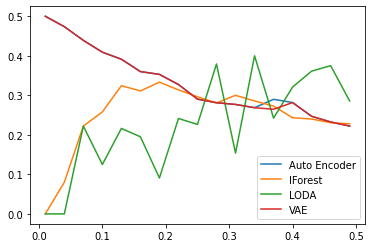

In [29]:
plt.plot(ae_accuracies.keys(), ae_accuracies.values(), label='Auto Encoder')
plt.plot(if_accuracies.keys(), if_accuracies.values(), label='IForest')
plt.plot(loda_accuracies.keys(), loda_accuracies.values(), label='LODA')
plt.plot(vae_accuracies.keys(), vae_accuracies.values(), label='VAE')
plt.legend()
plt.show()

## 4.5. ABOD

In [30]:
abod_accuracies={}
for x in np.arange(0.01,0.51,0.03):
    model_abod = ABOD(contamination=x)
    model_abod.fit(df_train.iloc[:,2:])
    preds_abod = model_abod.predict(df_test.iloc[:,2:])
    abod_accuracies[x] = metrics.f1_score(true, preds_abod)

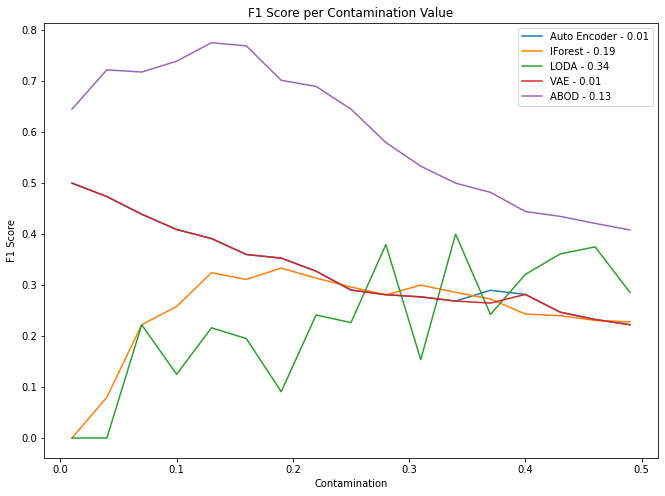

In [233]:
plt.figure(figsize=(11, 8))
plt.plot(ae_accuracies.keys(), ae_accuracies.values(), label='Auto Encoder - {}'.format(round(max(ae_accuracies, key=lambda key: ae_accuracies[key]), 2)))
plt.plot(if_accuracies.keys(), if_accuracies.values(), label='IForest - {}'.format(round(max(if_accuracies, key=lambda key: if_accuracies[key]), 2)))
plt.plot(loda_accuracies.keys(), loda_accuracies.values(), label='LODA - {}'.format(round(max(loda_accuracies, key=lambda key: loda_accuracies[key]), 2)))
plt.plot(vae_accuracies.keys(), vae_accuracies.values(), label='VAE - {}'.format(round(max(vae_accuracies, key=lambda key: vae_accuracies[key]), 2)))
plt.plot(abod_accuracies.keys(), abod_accuracies.values(), label='ABOD - {}'.format(round(max(abod_accuracies, key=lambda key: abod_accuracies[key]), 2)))
plt.legend()
plt.xlabel('Contamination')
plt.ylabel('F1 Score')
plt.title('F1 Score per Contamination Value')
plt.savefig('f1_contamination.png', dpi=300, bbox_inches='tight')
plt.show()

# 5. Train and Predict with Optimal Contamination:

In [32]:
max_cont_if = max(if_accuracies, key=lambda key: if_accuracies[key])
max_cont_ae = max(ae_accuracies, key=lambda key: ae_accuracies[key])
max_cont_vae = max(vae_accuracies, key=lambda key: vae_accuracies[key])
max_cont_loda = max(loda_accuracies, key=lambda key: loda_accuracies[key])
max_cont_abod = max(abod_accuracies, key=lambda key: abod_accuracies[key])

In [33]:
print('IForest optimal contamination: {:.2f}'.format(max_cont_if))
print('Auto Encoder optimal contamination: {:.2f}'.format(max_cont_ae))
print('VAE optimal contamination: {:.2f}'.format(max_cont_vae))
print('LODA optimal contamination: {:.2f}'.format(max_cont_loda))
print('ABOD optimal contamination: {:.2f}'.format(max_cont_abod))

IForest optimal contamination: 0.19
Auto Encoder optimal contamination: 0.01
VAE optimal contamination: 0.01
LODA optimal contamination: 0.34
ABOD optimal contamination: 0.13


In [34]:
model_if = IForest(n_estimators=100, contamination=0.19, n_jobs=-1, random_state=42)
model_ae = AutoEncoder(epochs=10, random_state=42, contamination=0.01)
model_vae = VAE(random_state=42, contamination=0.01, epochs = 10)
model_loda = LODA(contamination=0.34, n_bins=10, n_random_cuts=100)
model_abod = ABOD(contamination=0.13)

In [35]:
model_if.fit(df_train.iloc[:,2:])
model_ae.fit(df_train.iloc[:,2:])
model_vae.fit(df_train.iloc[:,2:])
model_loda.fit(df_train.iloc[:,2:])
model_abod.fit(df_train.iloc[:,2:])

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_306 (Dense)            (None, 4096)              16781312  
_________________________________________________________________
dropout_204 (Dropout)        (None, 4096)              0         
_________________________________________________________________
dense_307 (Dense)            (None, 4096)              16781312  
_________________________________________________________________
dropout_205 (Dropout)        (None, 4096)              0         
_________________________________________________________________
dense_308 (Dense)            (None, 64)                262208    
_________________________________________________________________
dropout_206 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_309 (Dense)            (None, 32)              

Epoch 1/10
19/19 [==============================] - 4s 139ms/step - loss: 2688.7912 - val_loss: 1540.4711
Epoch 2/10
19/19 [==============================] - 2s 120ms/step - loss: 2189.2006 - val_loss: 1382.3829
Epoch 3/10
19/19 [==============================] - 2s 116ms/step - loss: 2087.5309 - val_loss: 1354.7074
Epoch 4/10
19/19 [==============================] - 2s 127ms/step - loss: 2066.1976 - val_loss: 1341.0990
Epoch 5/10
19/19 [==============================] - 2s 117ms/step - loss: 1792.8640 - val_loss: 1344.2279
Epoch 6/10
19/19 [==============================] - 2s 117ms/step - loss: 2053.9285 - val_loss: 1345.8632
Epoch 7/10
19/19 [==============================] - 2s 122ms/step - loss: 1904.7808 - val_loss: 1341.0094
Epoch 8/10
19/19 [==============================] - 2s 122ms/step - loss: 1889.4841 - val_loss: 1344.3776
Epoch 9/10
19/19 [==============================] - 2s 128ms/step - loss: 1976.5814 - val_loss: 1340.4053
Epoch 10/10
19/19 [===========================

ABOD(contamination=0.13, method='fast', n_neighbors=5)

In [42]:
preds_if = model_if.predict(df_test.iloc[:,2:])
proba_preds_if = model_if.predict_proba(df_test.iloc[:,2:])[:,1]

preds_ae = model_ae.predict(df_test.iloc[:,2:])
proba_preds_ae = model_ae.predict_proba(df_test.iloc[:,2:])[:,1]

preds_vae = model_vae.predict(df_test.iloc[:,2:])
proba_preds_vae = model_vae.predict_proba(df_test.iloc[:,2:])[:,1]

preds_loda = model_loda.predict(df_test.iloc[:,2:])
proba_preds_loda = model_loda.predict_proba(df_test.iloc[:,2:])[:,1]

preds_abod = model_abod.predict(df_test.iloc[:,2:])
proba_preds_abod = model_abod.predict_proba(df_test.iloc[:,2:])[:,1]

# 6. Evaluate:

In [81]:
import math
def calc_error(y_true, y_pred):
    error = sum(((y_true == 1) & (y_pred == 0))) / sum(y_true)
    return error

def calc_conf_interval(score, n=df_test.shape[0], const=1.96):
    lower_bound = score - const * math.sqrt( (score * (1 - score)) / n)
    upper_bound = score + const * math.sqrt( (score * (1 - score)) / n)
    
    return lower_bound, upper_bound

## 6.1. F1-score with Confidence Interval:

In [93]:
f1_if = metrics.f1_score(true, preds_if)
f1_ae = metrics.f1_score(true, preds_ae)
f1_vae = metrics.f1_score(true, preds_vae)
f1_loda = metrics.f1_score(true, preds_loda)
f1_abod = metrics.f1_score(true, preds_abod)

In [94]:
print('IForest score: {:.2f}'.format(float(f1_if)))
print('AE score: {:.2f}'.format(float(f1_ae)))
print('LODA score: {:.2f}'.format(float(f1_vae)))
print('VAE score: {:.2f}'.format(float(f1_loda)))
print('ABOD score: {:.2f}'.format(float(f1_abod)))

IForest score: 0.33
AE score: 0.50
LODA score: 0.50
VAE score: 0.25
ABOD score: 0.78


In [172]:
f1_conf_if = calc_conf_interval(f1_if)
f1_conf_ae = calc_conf_interval(f1_ae)
f1_conf_vae = calc_conf_interval(f1_vae)
f1_conf_loda = calc_conf_interval(f1_loda)
f1_conf_abod = calc_conf_interval(f1_abod)

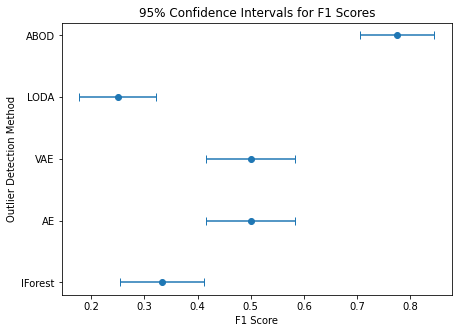

In [239]:
from scipy import stats

plt.figure(figsize=(7, 5))

scores_list = [f1_if, f1_ae, f1_vae, f1_loda, f1_abod]
W_list = np.array([f1_conf_if, f1_conf_ae, f1_conf_vae, f1_conf_loda, f1_conf_abod])

plt.errorbar(x=scores_list, y=range(len(scores_list)), xerr=scores_list-W_list[:,0], fmt='o', capsize=4)
plt.yticks(ticks=[0, 1, 2, 3, 4], labels=['IForest', 'AE', 'VAE', 'LODA', 'ABOD'])
plt.xlabel('F1 Score')
plt.ylabel('Outlier Detection Method')
plt.title('95% Confidence Intervals for F1 Scores')
plt.savefig('f1_conf_interval.png', bbox_inches='tight', dpi=300)
plt.show();

## 6.2. Error with Confidence Interval:

In [169]:
error_if = calc_error(true, preds_if)
error_ae = calc_error(true, preds_ae)
error_vae = calc_error(true, preds_vae)
error_loda = calc_error(true, preds_loda)
error_abod = calc_error(true, preds_abod)

In [170]:
err_conf_if = calc_conf_interval(error_if)
err_conf_ae = calc_conf_interval(error_ae)
err_conf_vae = calc_conf_interval(error_vae)
err_conf_loda = calc_conf_interval(error_loda)
err_conf_abod = calc_conf_interval(error_abod)

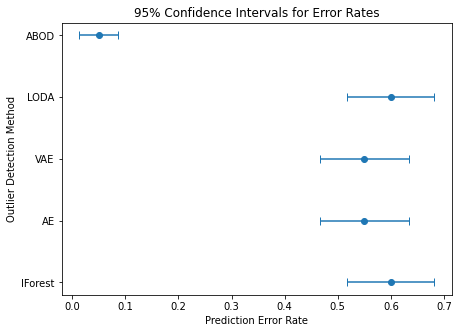

In [240]:
plt.figure(figsize=(7, 5))

scores_list = [error_if, error_ae, error_vae, error_loda, error_abod]
W_list = np.array([err_conf_if, err_conf_ae, err_conf_vae, err_conf_loda, err_conf_abod])

plt.errorbar(x=scores_list, y=range(len(scores_list)), xerr=scores_list-W_list[:,0], fmt='o', capsize=4)
plt.yticks(ticks=[0, 1, 2, 3, 4], labels=['IForest', 'AE', 'VAE', 'LODA', 'ABOD'])
plt.xlabel('Prediction Error Rate')
plt.ylabel('Outlier Detection Method')
plt.title('95% Confidence Intervals for Error Rates')
plt.savefig('err_conf_interval.png', bbox_inches='tight', dpi=300)
plt.show();

## 6.3. ROC-AUC:

In [157]:
fpr_if, tpr_if, threshold_if = metrics.roc_curve(true, model_if.predict_proba(df_test.iloc[:,2:])[:,1])
fpr_ae, tpr_ae, threshold_ae = metrics.roc_curve(true, model_ae.predict_proba(df_test.iloc[:,2:])[:,1])
fpr_loda, tpr_loda, threshold_loda = metrics.roc_curve(true, model_loda.predict_proba(df_test.iloc[:,2:])[:,1])
fpr_vae, tpr_vae, threshold_vae = metrics.roc_curve(true, model_vae.predict_proba(df_test.iloc[:,2:])[:,1])
fpr_abod, tpr_abod, threshold_abod = metrics.roc_curve(true, model_abod.predict_proba(df_test.iloc[:,2:])[:,1])

roc_auc_if = metrics.auc(fpr_if, tpr_if)
roc_auc_ae = metrics.auc(fpr_ae, tpr_ae)
roc_auc_loda = metrics.auc(fpr_loda, tpr_loda)
roc_auc_vae = metrics.auc(fpr_vae, tpr_vae)
roc_auc_abod = metrics.auc(fpr_abod, tpr_abod)

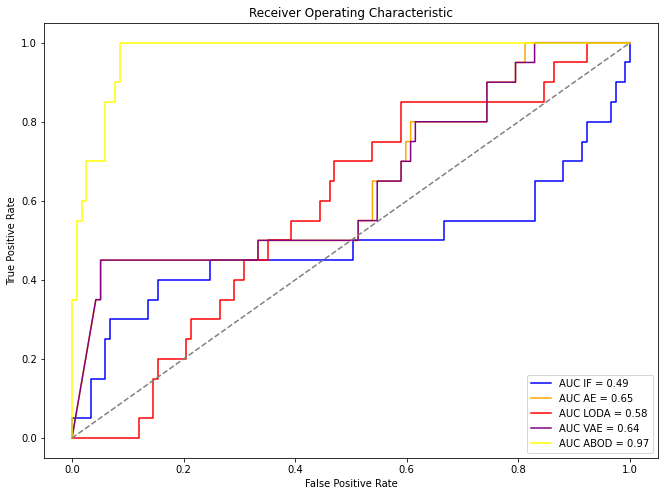

In [158]:
plt.figure(figsize=(11, 8))

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_if, tpr_if, 'b', color = 'blue', label = 'AUC IF = %0.2f' % roc_auc_if)
plt.plot(fpr_ae, tpr_ae, 'b', color = 'orange', label = 'AUC AE = %0.2f' % roc_auc_ae)
plt.plot(fpr_loda, tpr_loda, 'b', color = 'red', label = 'AUC LODA = %0.2f' % roc_auc_loda)
plt.plot(fpr_vae, tpr_vae, 'b', color = 'purple', label = 'AUC VAE = %0.2f' % roc_auc_vae)
plt.plot(fpr_abod, tpr_abod, 'b', color = 'yellow', label = 'AUC ABOD = %0.2f' % roc_auc_abod)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--', color = 'grey')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('roc_auc.png', dpi=300, bbox_inches='tight')
plt.show()

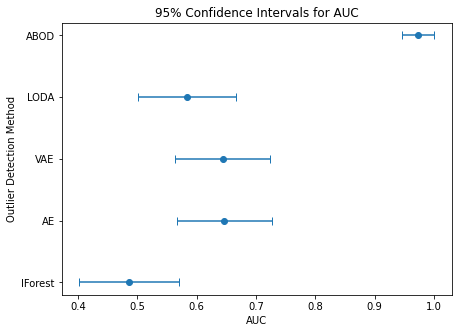

In [241]:
plt.figure(figsize=(7, 5))

scores_list = [roc_auc_if, roc_auc_ae, roc_auc_vae, roc_auc_loda, roc_auc_abod]
W_list = np.array([calc_conf_interval(x) for x in scores_list])

plt.errorbar(x=scores_list, y=range(len(scores_list)), xerr=scores_list-W_list[:,0], fmt='o', capsize=4)
plt.yticks(ticks=[0, 1, 2, 3, 4], labels=['IForest', 'AE', 'VAE', 'LODA', 'ABOD'])
plt.xlabel('AUC')
plt.ylabel('Outlier Detection Method')
plt.title('95% Confidence Intervals for AUC')
plt.savefig('auc_conf_interval.png', bbox_inches='tight', dpi=300)
plt.show()

## 6.4. Confusion Matrices:

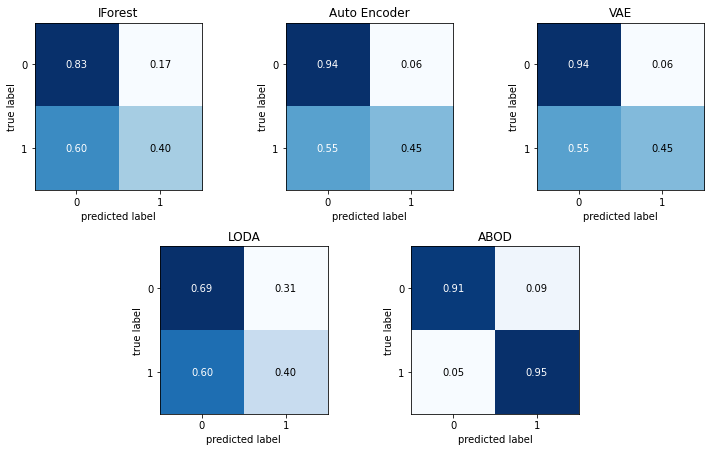

In [247]:
from mlxtend.plotting import plot_confusion_matrix
grid_m = 2
grid_n = 3

fig = plt.figure(figsize=(12,10))
fig.tight_layout()
axes = [plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2, fig=fig),
        plt.subplot2grid((2,6), (0,2), colspan=2, fig=fig),
        plt.subplot2grid((2,6), (0,4), colspan=2, fig=fig),
        plt.subplot2grid((2,6), (1,1), colspan=2, fig=fig),
        plt.subplot2grid((2,6), (1,3), colspan=2, fig=fig)]

models = [model_if, model_ae, model_vae, model_loda, model_abod]
all_preds = [preds_if, preds_ae, preds_vae, preds_loda, preds_abod]
cm = [metrics.confusion_matrix(true, pred) for pred in all_preds]
names = ['IForest', 'Auto Encoder', 'VAE', 'LODA', 'ABOD']

for i in range(len(models)):
    fig, ax = plot_confusion_matrix(conf_mat=cm[i], show_normed=True,
                                    show_absolute=False, axis=axes[i], figure=fig)
    axes[i].set_title('{}'.format(names[i]))
    axes[i].set_xlabel('predicted label')
    axes[i].set_ylabel('true label')
fig.subplots_adjust(wspace=2, hspace=-0.3)
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()